# Time Series 

In this file, I am going to handle time series data to predict temperature after 24h and show dropout, stacking and bidirectional

## 1. Data load

In [1]:
import os

data_dir = 'C:/python/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

# csv file consists of \n and comma

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


##### Transform into numpy array

In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1)) # Zero (empty) array

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

##### Every data

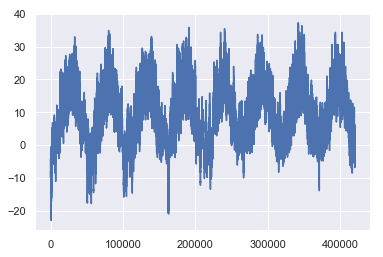

In [15]:
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

##### 10 days

plt.plot(range(1440), temp[:1440])

## 2. Preprocess for modeling

We go back before 10 days and use 10 days data to predict temperature after 24hours.

- lookback = 1440: back to before 10 days
- steps = 6: sampling each data point every 1 hours (1 means 10 minutes)
- delay = 144: target (after 24 hours)

For this, we need function to generate data

Before we define function, we need to standardize data.

##### Standardize

In [16]:
mean = float_data[:200000].mean(axis=0)
std = float_data[:200000].std(axis=0)

float_data = (float_data - mean) / std

##### Data generator

To save memory (not loading all data samples), generating each train samples is more efficient.

(In training, we randomly pick one data and gather 10 days (240 data points) data to train.)

In [32]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arrange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

##### For training, dev, test

In [33]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 3. Model

In machine learning model, we can measure its performance by comparing to naive method, like 50% accuracy with predicting all tossed

coin would be front. In this data, we can predict temperature after 24hours as same as present temperature.

#####  Naive method



In [34]:
float_data[:, 1]

array([-1.93135845, -1.97541381, -1.98671006, ..., -1.38236094,
       -1.50323076, -1.56987861])

In [37]:
def evaluate_naive_method():
    batch_maes =[]
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2908773835565898


This is value that deeplearning or more complex model have to exceed.

##### GRU

In [41]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = optimizers.RMSprop(), loss = 'mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 128s 255ms/step - loss: 0.3053 - val_loss: 0.2753
Epoch 2/20
500/500 [==============================] - 125s 250ms/step - loss: 0.2843 - val_loss: 0.2678
Epoch 3/20
500/500 [==============================] - 126s 252ms/step - loss: 0.2786 - val_loss: 0.2629
Epoch 4/20
500/500 [==============================] - 124s 248ms/step - loss: 0.2742 - val_loss: 0.2662
Epoch 5/20
500/500 [==============================] - 128s 255ms/step - loss: 0.2690 - val_loss: 0.2688
Epoch 6/20
500/500 [==============================] - 139s 278ms/step - loss: 0.2633 - val_loss: 0.2626
Epoch 7/20
500/500 [==============================] - 131s 261ms/step - loss: 0.2579 - val_loss: 0.2637
Epoch 8/20
500/500 [==============================] - 132s 264ms/step - loss: 0.2532 - val_loss: 0.2656
Epoch 9/20
500/500 [==============================] - 145s 291ms/step - loss: 0.2493 - val_loss: 0.2696
Epoch 10/20
500/500 [==============================] - 135s 270m

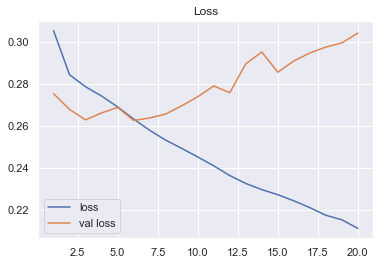

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title('Loss')

plt.legend()
plt.show()

We get much better model to predict temperature. But it shows overfitting after few epochs.

Then, we need to find more stable model by regularizing and increase networks after that.

##### Dropout to regularize

There are two kinds of dropout in recurrent neural networks. Dropout for input and dropout in recurrent state.

We can assign probability of deactivating neuron with dropout and recurrnet_dropout parameter.

After get more stable model, it is quite reasonable to stack rnn layers to increase network size. 

But I'll skip those process in this notebooks.

In [ ]:
'''
model = models.Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)
                              '''

